In [1]:
# General Module
import pandas as pd
import re

from konlpy.tag import Kkma

# Visualization
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import operator
import numpy as np
from nltk import bigrams, ConditionalFreqDist
import matplotlib.font_manager as fm
from matplotlib import rc

In [2]:
texts = """
영국이 코로나19 바이러스의 새로운 변이 ‘뉴’에 대해 “최악”이라고 평가하며 긴급히 대응에 나섰다.

영국 보건안전청(HSA)은 아프리카 남부를 중심으로 출현한 뉴 변이에 대해 “지금까지 본 것들 가운데 최악”이라며 스파이크(돌기) 단백질이 극적으로 다르다고 평가했다고 로이터통신이 26일(현지시간) 전했다.

제니 해리스 보건안전청장은 “역대 가장 중대한(significant) 변이이며 전파력, 심각성, 백신 효과 등에 관해 긴급 연구를 하고 있다”고 말했다.

뉴 변이는 23일 남아프리카공화국에서 처음 보고됐으며, 이후 인접국 보츠와나와 멀리 떨어진 홍콩 등에서도 나왔다.

홍콩에서 보고된 사례는 남아공을 20일간 방문하고 돌아온 36세 남성으로, 귀국 이틀 만에 격리 중 확진 판정을 받았다.

과학자들이 뉴 변이에 극도로 긴장하는 이유는 바이러스의 세포 침투 과정에서 ‘열쇠’ 역할을 하는 돌기 모양의 스파이크 단백질에서만 무려 32개의 변이가 발견됐기 때문이다. 강한 전파력을 지닌 델타 변이의 스파이크 단백질 돌연변이는 16개였다.

코로나19 바이러스는 스파이크 단백질이 숙주 세포에 결합하는 방식으로 침투하는데, 바이러스의 변이 과정에서 침투가 더 잘 되는 돌연변이를 가진 바이러스가 살아남아 하나의 변이종으로 확립되는 것이다.

델타 변이가 처음 인간 사이에 퍼졌던 초기 바이러스에 비해 16개의 변이된 돌기, 즉 열쇠를 통해 세포의 문을 열려고 했다면 뉴 변이는 32개의 열쇠로 세포 면역 해제를 시도한다는 점에서 잠재적인 위험이 더 클 것으로 의학계는 우려하고 있다.

현재 개발된 백신들은 스파이크 단백질의 일부를 알아채도록 훈련돼 있는데, 스파이크 단백질에 변이가 32개나 존재한다는 것은 우리 면역 체계가 새 변이를 기존 바이러스와 다른 것으로 오인하게 만들어 백신의 효과를 떨어뜨릴 수 있다고 전문가들은 지적한다.

영국은 전날 남아공을 포함해 아프리카 6개국의 항공편 운항을 중단하고, 귀국하는 자국민은 호텔격리 하기로 하는 등 신속 대응에 나섰다.

그랜트 샙스 영국 교통장관은 이날 인터뷰에서 보건안전청 발표를 인용하며 “영국은 안전을 우선으로 하고 있다”며 “코로나19 사태에서 얻은 교훈은 조기 조치가 필수라는 점”이라고 말했다.

세계보건기구(WHO)도 점점 커지는 우려에 26일 긴급회의를 열어 뉴 변이를 ‘주요 변이’로 지정할지 논의한다.
"""

In [19]:
class TextMining:
    def __init__(self, text, pos_table_root='./processed-data/pos-table.pkl', kor_stopwords_root='./Data/Kor_stopwords.txt'):
        text = [text]

        cleaned = self.cleaning(text)

        tagged = self.tagging(cleaned)

        tagList = pd.read_pickle(pos_table_root)
        stop_tag_list = ['IC', 'JC', 'JK', 'JKC', 'JKG', 'JKI', 'JKM', 'JKO', 'JKQ', 'JKS', 'JX', 'EPH', \
            'EPT', 'EPP', 'EFN', 'EFQ', 'EFO', 'EFA', 'EFI', 'EFR', 'ECE', 'ECD', 'ECS', 'ETN', 'ETD',
            'XSN', 'XSV', 'XSA', 'UN', 'OH', 'OL', 'ON', 'XPN', 'XPV', 'XR']
        Kor_stopwords = ''
        with open(kor_stopwords_root, 'r', encoding='utf-8') as f:
            stopword = f.read()
            Kor_stopwords = stopword
        Kor_stopwords = Kor_stopwords.split('\n')

        wo_stopword = self.remove_stopword(tagged, stop_tag_list, Kor_stopwords)

        self.tokenized = self.tokenizing(wo_stopword, tagList, 'noun')
    
    def cleaning(self, data):
        result=[]

        for text in data:
            result.append(re.sub('[^A-Za-z가-힣 ]', '', text))
        
        return result
    
    def tagging(self, articles):
        result = []

        kkma = Kkma()

        for article in articles:
            result.append(kkma.pos(article))
        
        return result
    
    def remove_stopword(self, data, stop_tag_list, Kor_stopwords):
        result = []

        for tags in data:
            arr = []
            for tag in tags:
                if (tag[1] not in stop_tag_list) & (tag[0] not in Kor_stopwords) & (len(tag[0]) != 1):
                    arr.append(tag)
            result.append(arr)

        return result
    
    def tokenizing(self, data, tagList, pos='all'):
        if pos == 'noun':
            nouns = []
            for article in data:
                tags = []
                for tag in article:
                    if tag[1] in tagList.Kor_tag[0]:
                        tags.append(str(tag[0]))
                nouns.append(tags)
            return nouns
        
        elif pos == 'verb':
            verb=[]
            for article in data:
                tags = []
                for tag in article:
                    if tag[1] in tagList.Kor_tag[2]:
                        tags.append(str(tag[0]))
                verb.append(tags)
            return verb
        
        elif pos == 'adjective':
            adjective = []
            for article in data:
                tags = []
                for tag in article:
                    if tag[1] in tagList.Kor_tag[3]:
                        tags.append(str(tag[0]))
                adjective.append(tags)
            return adjective
        
        elif pos == 'adverb':
            adverb = []
            for article in data:
                tags = []
                for tag in article:
                    if tag[1] in tagList.Kor_tag[4]:
                        tags.append(str(tag[0]))
                adverb.append(tags)
            return adverb            
        
        elif pos == 'all':
            all = []
            for article in data:
                tokens = []
                for tag in article:
                    tokens.append(str(tag[0]))
                all.append(tokens)
            return all
        
        else :
            print("Invalid POS mode! must be one of : 'noun', 'verb', 'adjective', 'adverb', 'all'")
            return -1
    
    def gen_Network(self):
        bgrams = [bigrams(tokens) for tokens in self.tokenized]

        token = []
        for bgram in bgrams:
            token += ([x for x in bgram])
        
        cfd = ConditionalFreqDist(token)
        freq_mat = []

        for i in cfd.keys():
            temp = []
            for j in cfd.keys():
                temp.append(cfd[i][j])
            freq_mat.append(temp)
        freq_mat = np.array(freq_mat)
        freq_df = pd.DataFrame(freq_mat, index=cfd.keys(), columns=cfd.keys())

        co_occurrence_dict = {}
        for idx in range(len(freq_df)):
            co_occurrence_dict[str(idx)] = freq_df.iloc[idx, :].max()
        sorted_co_occurrence_dict = sorted(co_occurrence_dict.items(), key = lambda item: item[1], reverse=True)
        top_N = sorted_co_occurrence_dict[:30]
        top_N_idx = []
        for idx, _ in top_N:
            top_N_idx.append(int(idx))
    
        self.G = nx.from_pandas_adjacency(freq_df.iloc[top_N_idx, :])

        dgr = nx.degree_centrality(self.G)
        self.dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)

        cls = nx.closeness_centrality(self.G)
        self.cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)

        btw = nx.betweenness_centrality(self.G)
        self.btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)

        eig = nx.eigenvector_centrality(self.G)
        self.eig = sorted(eig.items(), key=operator.itemgetter(1), reverse=True)
    
    def save_Network(self, title='Semantic Analysis', root='./', centrality='degree'):
        if centrality == 'degree':
            title = title + ' (Degree Centrality)'
            centrality_value = self.dgr
        elif centrality == 'closeness':
            title = title + ' (Closeness Centrality)'
            centrality_value = self.cls
        elif centrality == 'betweenness':
            title = title + ' (Betweenness Centrality)'
            centrality_value = self.btw
        elif centrality == 'eigenvector':
            title = title + ' (Eigenvector Centrality)'
            centrality_value = self.eig

        for token, central in centrality_value:
            self.G.nodes[token]['weight'] = central

        fig = plt.figure(figsize=(30, 20))
        plt.margins(x=0.1, y=0.2)
        plt.rc('font', family='Malgun Gothic')
        font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
        ax = fig.gca()

        # edge와 node의 label 부여하기
        node_labels = dict((token, token) for token, _ in self.G.nodes(data=True))
        try :
            pos = graphviz_layout(self.G, prog='neato')
        except : 
            pos = nx.layout.fruchterman_reingold_layout(self.G)
        nx.draw_networkx_labels(self.G, pos, font_family=font_name, labels=node_labels)

        # Node에 centrality에 따라 weight 부여
        Blues_modified = cm.get_cmap('Blues', 256)
        newcmp = ListedColormap(Blues_modified(np.linspace(0.2, 0.8, 4)))
        nc = nx.draw_networkx_nodes(self.G, pos, 
            node_size=[node[1]["weight"]*20000 for node in self.G.nodes(data=True)],
            node_color=[node[1]['weight'] for node in self.G.nodes(data=True)], 
            cmap=newcmp, node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # Edge에 co-occurrence에 따라 weight 부여
        Greys_modified = cm.get_cmap('Greys', 256)
        newcmp = ListedColormap(Greys_modified(np.linspace(0.2, 1.0, 4)))
        ec = nx.draw_networkx_edges(self.G, pos, 
            edge_color=[edge[2]['weight'] for edge in self.G.edges(data=True)],
            edge_cmap=newcmp, style='solid', width=2)

        # Title 설정
        plt.title(title, fontsize=25)
        plt.axis('off')

        axins = inset_axes(ax,
                    width='1%',
                    height='30%',
                    loc='center right',
                    borderpad=0)
        cbar = plt.colorbar(nc, cax=axins)
        cbar.ax.set_ylabel('Centrality', rotation=270, fontsize=12, labelpad=15)

        axins = inset_axes(ax,
            width='1%',
            height='30%',
            loc='center left',
            borderpad=0)
        cbar = plt.colorbar(ec, cax=axins)
        cbar.ax.set_ylabel('Word Pair Freqency', rotation=270, fontsize=12, labelpad=15)

        plt.savefig(root+title+'.png')

In [20]:
text = TextMining(text=texts)

In [21]:
text.gen_Network()

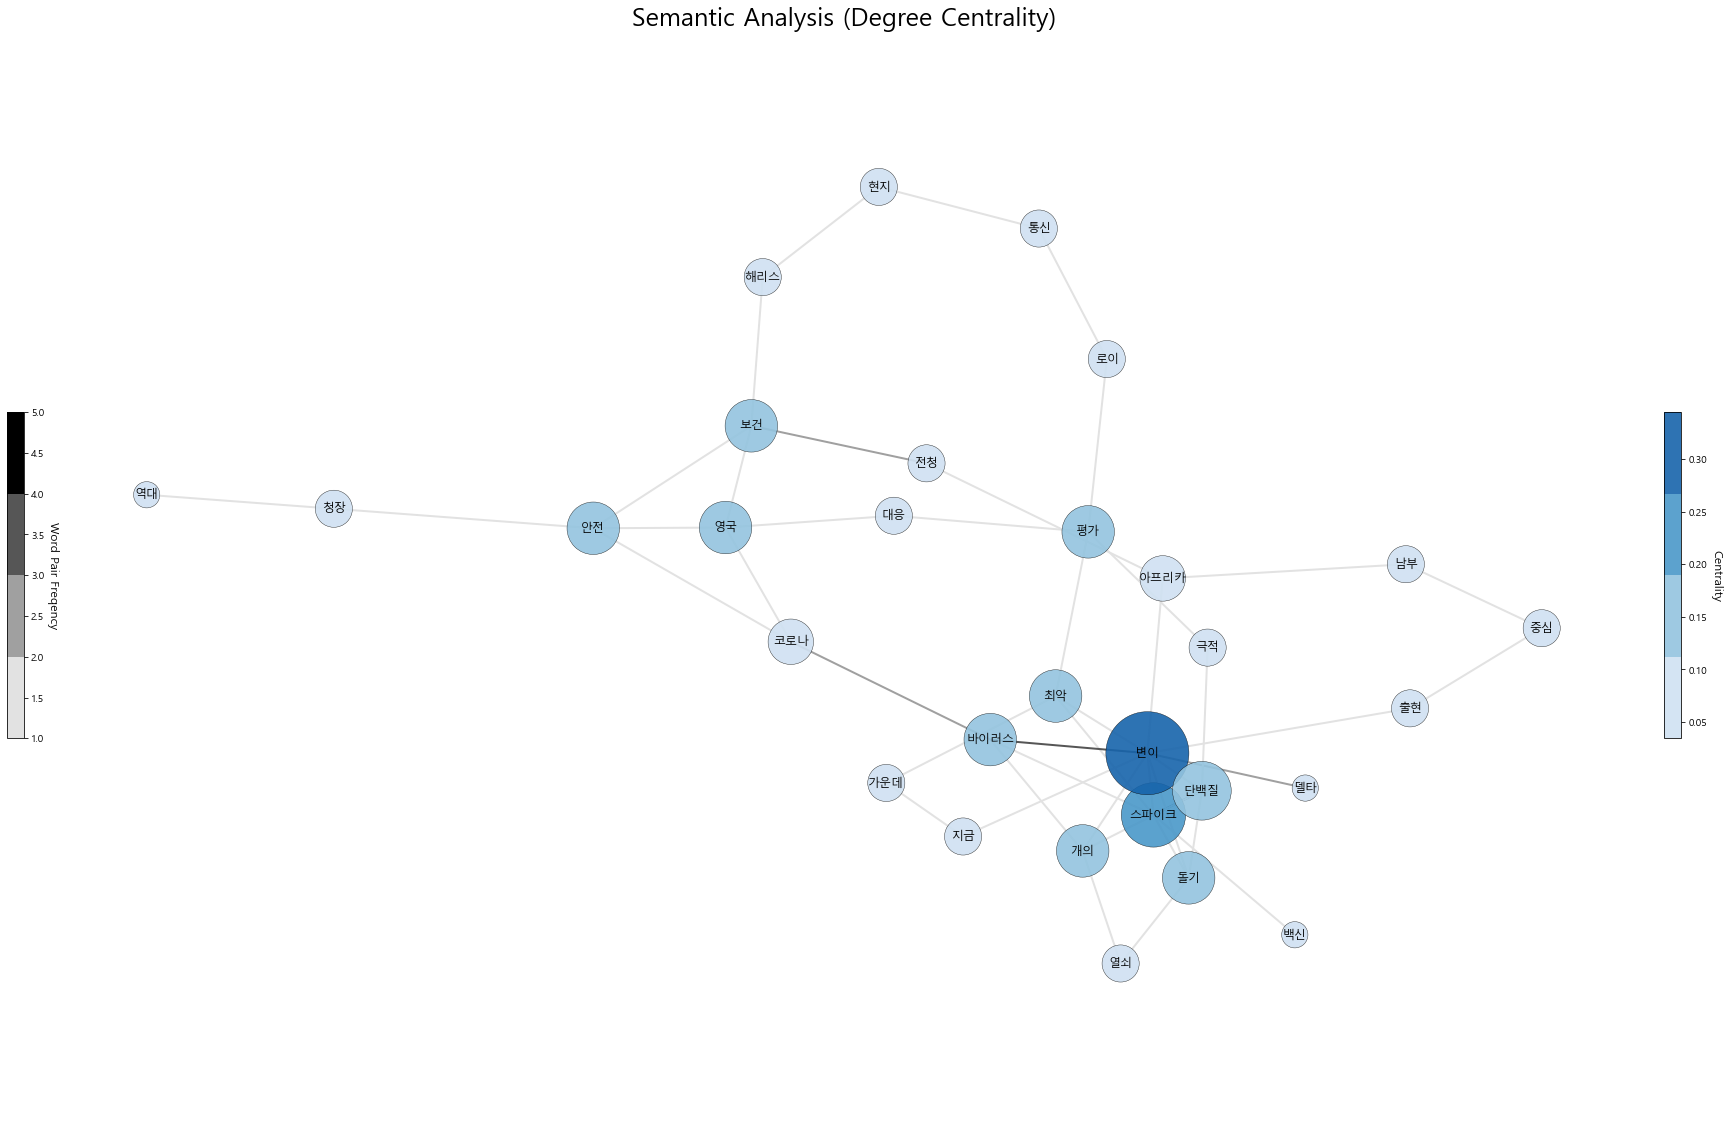

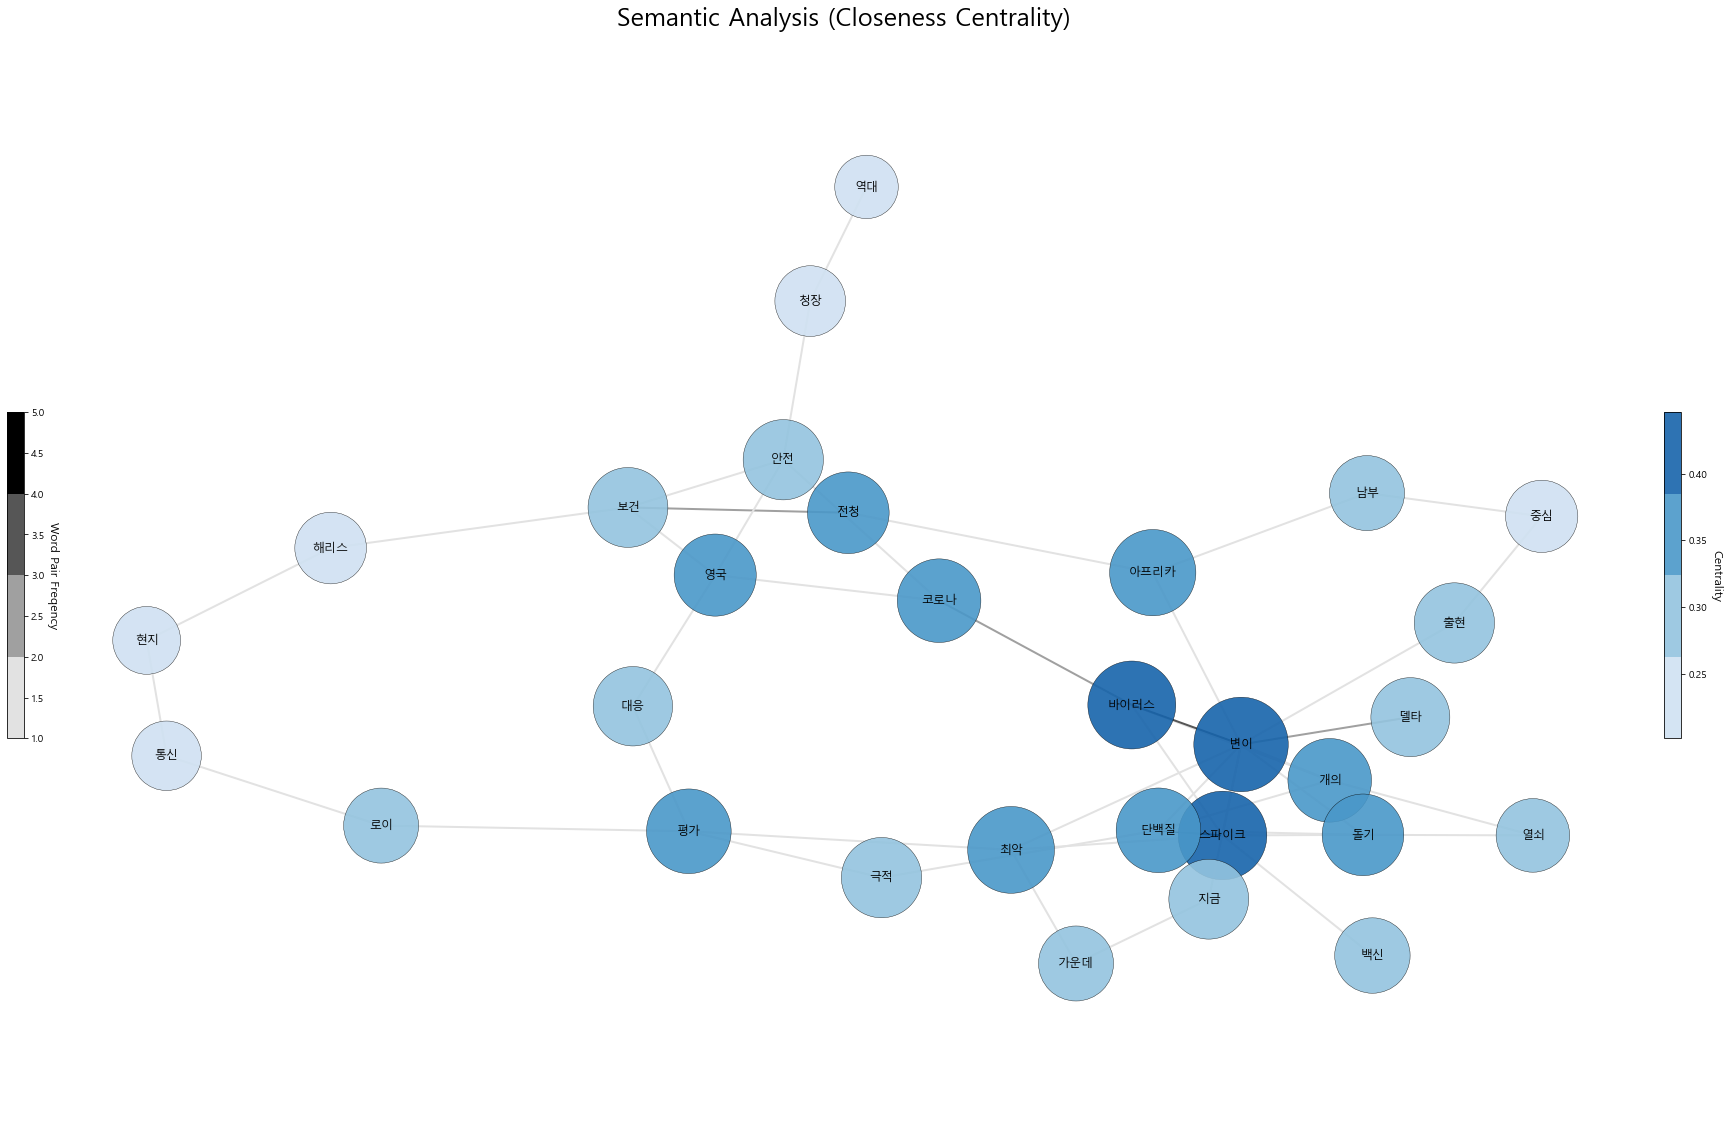

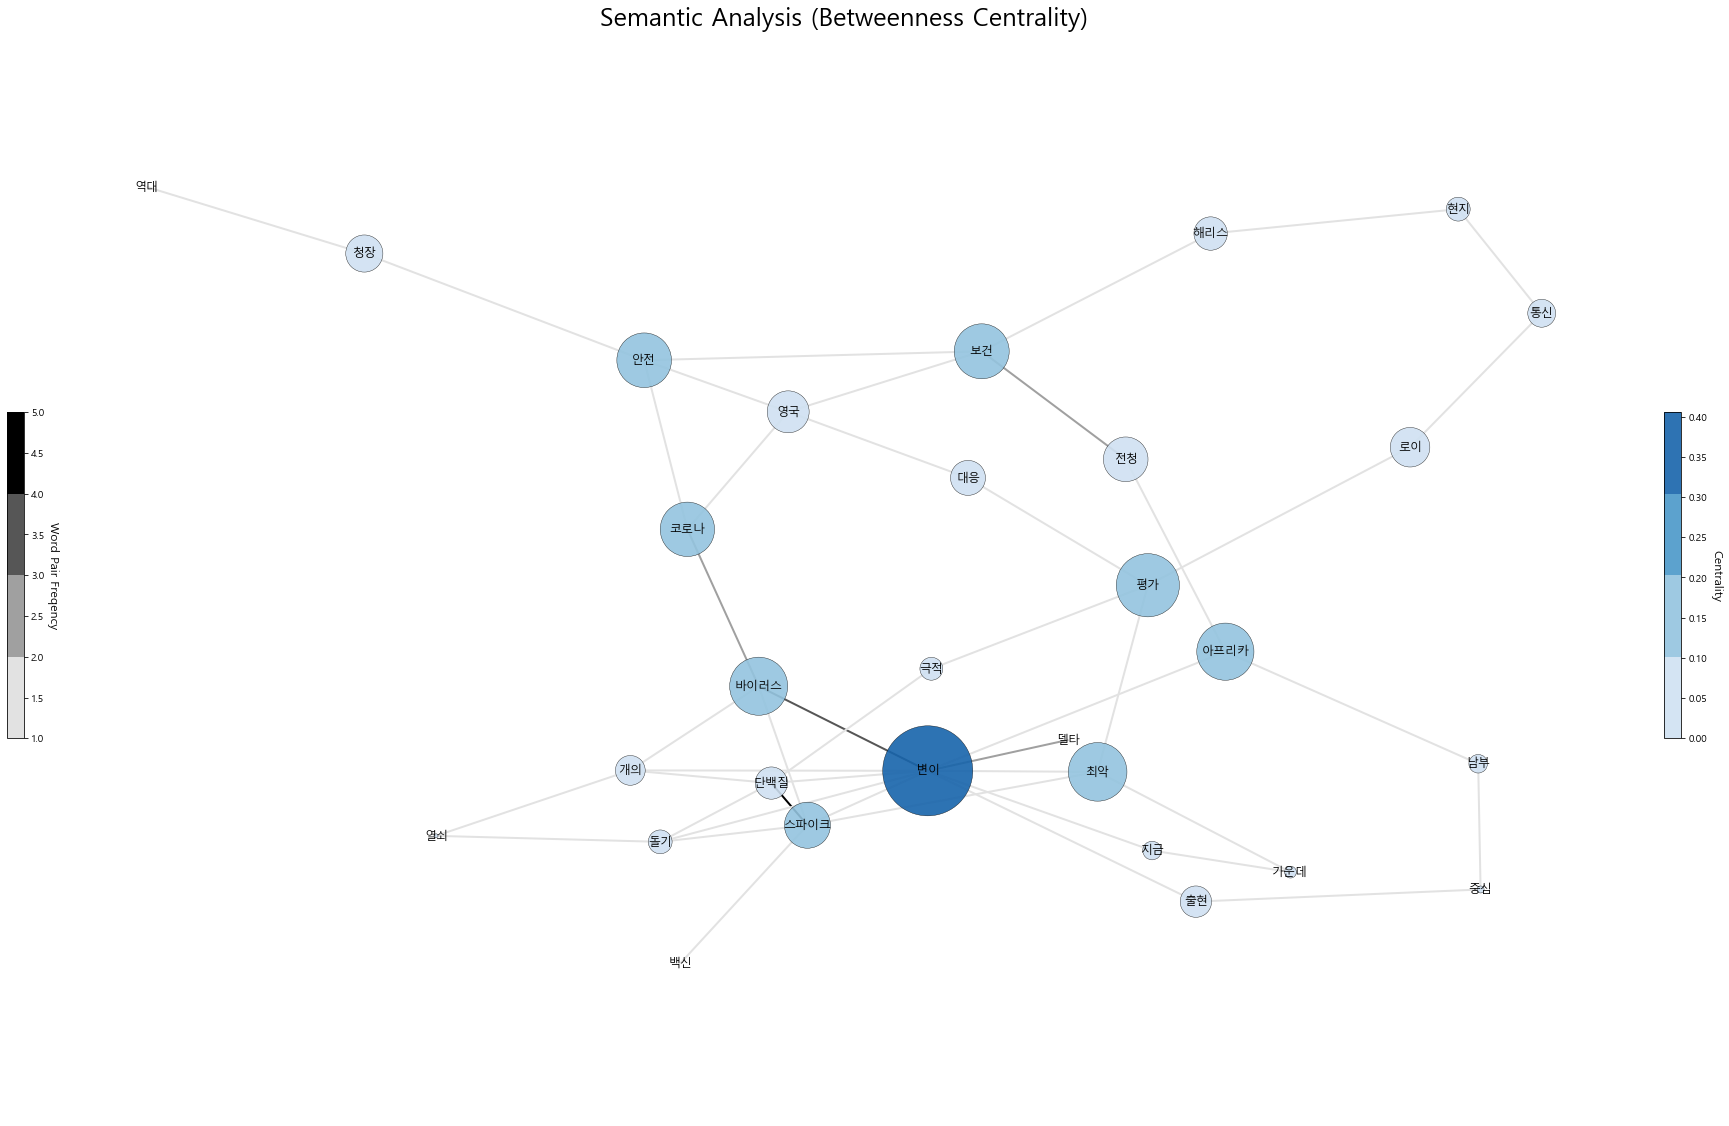

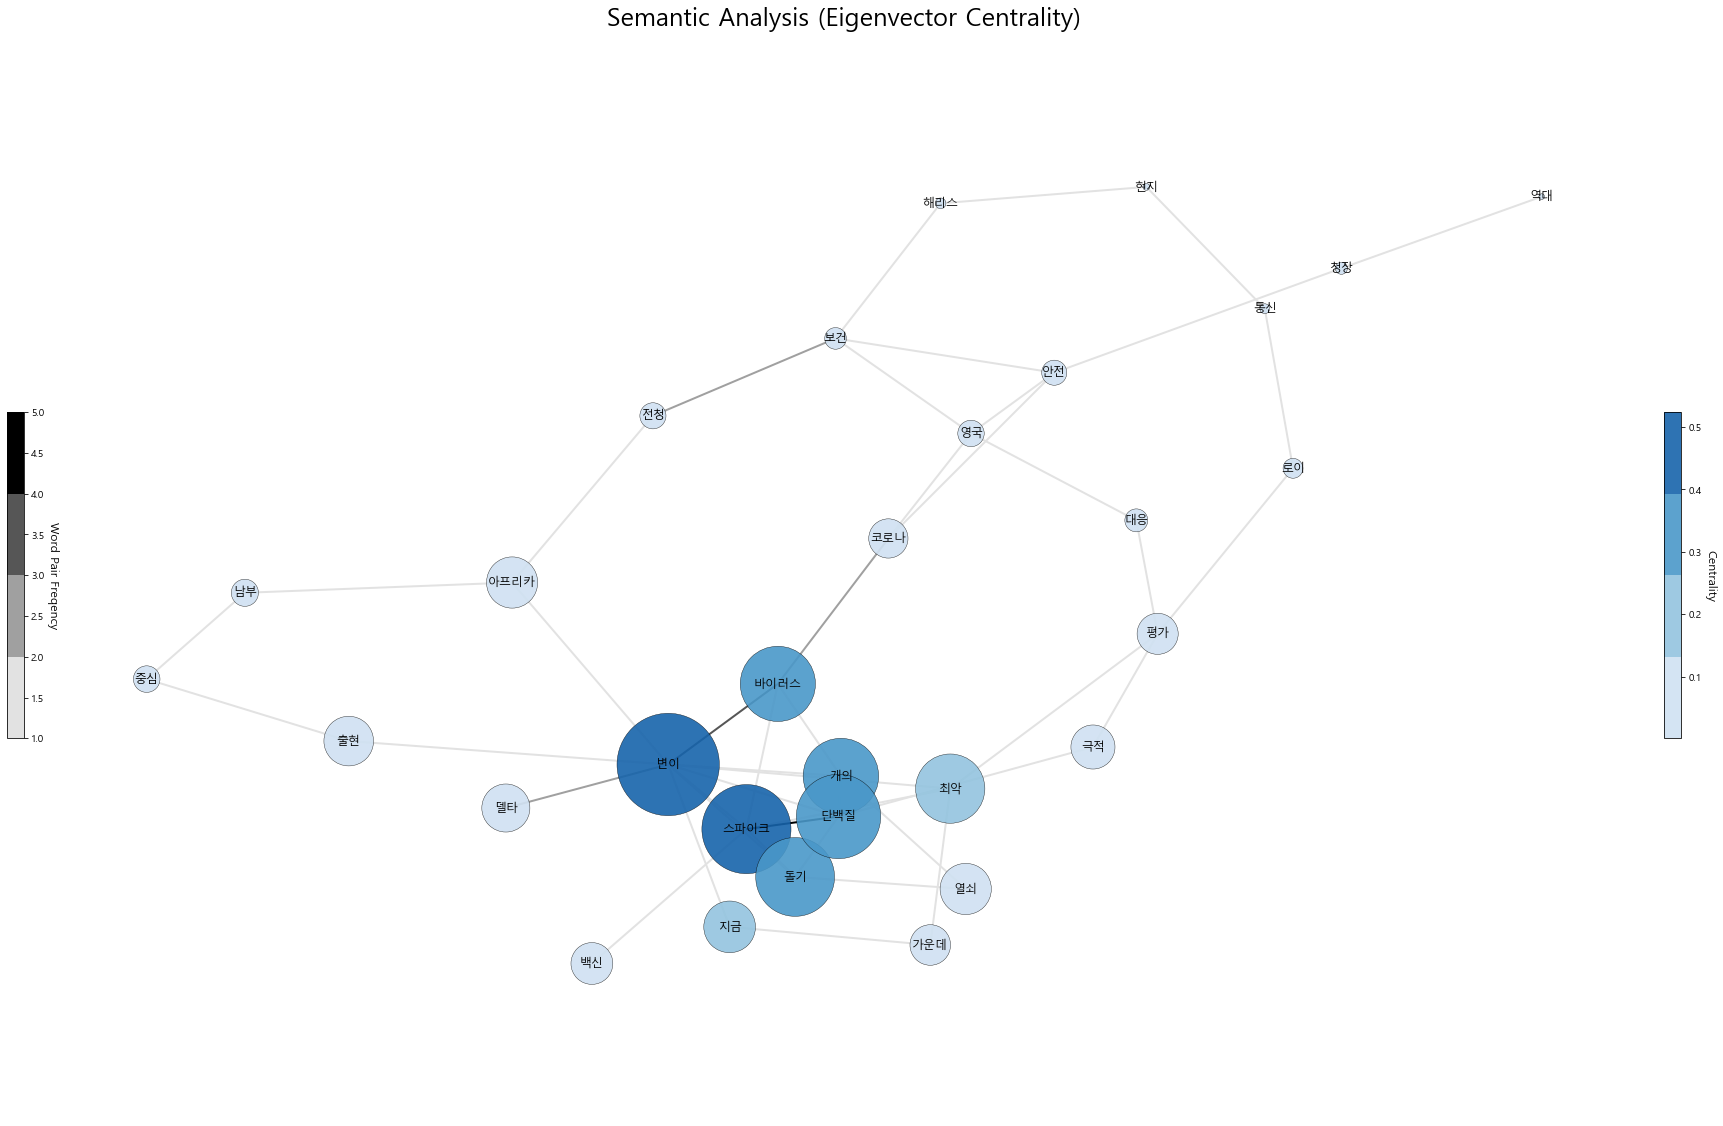

In [22]:
text.save_Network(centrality='degree')
text.save_Network(centrality='closeness')
text.save_Network(centrality='betweenness')
text.save_Network(centrality='eigenvector')